<a href="https://colab.research.google.com/github/Where-Is-The-Exit/271B-project/blob/main/ECE271B_Projectv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split as tts
import scipy

In [2]:
!git clone https://github.com/RicardoRamirez2020/GCN_Cancer

fatal: destination path 'GCN_Cancer' already exists and is not an empty directory.


In [3]:
cd GCN_Cancer

/content/GCN_Cancer


In [4]:
cd GCN_Cancer

/content/GCN_Cancer/GCN_Cancer


In [5]:
%tensorflow_version 1.x
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tensorflow-gpu==1.15.0
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
import sys
#sys.path.append("C:\Users\David\Downloads\lib\graph") 
from lib import graph
#sys.path.append("/Users/david/Downloads/lib/coarsening") 
from lib import coarsening
#sys.path.append("/Users/david/Downloads/lib/models") 
from lib import models
from lib import utils

TensorFlow 1.x selected.


Using TensorFlow backend.


In [6]:
#Start writing co_1_7 = pd.ExcelFile('/work/beng212_1_7.xlsx')
_1_7 = pd.ExcelFile('beng212_1_7 (1).xlsx')
#population_dist = pd.read_excel(_1_7,sheet_name = 'population_dist',header = 0)
#metagenome_dem = pd.read_excel(_1_7,sheet_name = 'metagenome_demographics',header = 0)
#metabolome_dem = pd.read_excel(_1_7,sheet_name = 'metabolome_demographics',header = 0)
#metagenome_clinical = pd.read_excel(_1_7,sheet_name = 'metagenome_clinical',header = 0)
metabolome_clinical = pd.read_excel(_1_7,sheet_name = 'metabolome_clinical',header = 0)
#charged_metabolites = pd.read_excel(_1_7,sheet_name = 'charged_metabolites_list',header = 0)
#kegg_codes = pd.read_excel(_1_7,sheet_name = 'kegg_codes',header = 0)
#kegg_orth_ids = pd.read_excel(_1_7,sheet_name = 'kegg_orth_IDs',header = 0)
#metabolite_profiles = pd.read_excel("paper_data.xlsx", sheet_name = 'Table_S13', header = 0, skiprows = lambda x: x in [0,1,2])
metabolite_profiles = pd.read_csv("metabolite_profiles.csv")
metabolite_profiles=metabolite_profiles.rename(columns={'Unnamed: 0':'Metabolites'})

#metagenomic_data = pd.read_excel(_1_7,sheet_name = 'patient_metagenomic_data',header = 0)de here...
#metabolome_dem

In [7]:
#metabolite_profiles.to_csv("metabolite_profiles.csv")

In [8]:
X = metabolite_profiles.transpose()
X = X.rename(columns=X.iloc[0])
X = X.loc[~(X==0).all(axis=1)]
X = X.drop(X.index[0])
X = X.sort_index(axis = 0)
#Pval = calculate_pvalues(X.transpose())
#Pval[Pval<=.0001]=1
#Pval[(Pval>.0001) & (Pval<1)] = 0
#Pval
y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')
y = y.replace('Healthy', 1)
y = y.replace('Cancer', 2)

In [9]:
X = X.astype("float32")
Cor = X.corr(method='spearman')
Cor[abs(Cor)>.5]=1
Cor[abs(Cor)<.5]=0
#drop_indices = C[(C == 0).sum(axis=1)>=(len(C.columns)-1)].index
#C = C.drop(drop_indices)
#C
Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
Cor.index
X = X[Cor.index]

### Logistic Regression

In [10]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3, random_state=0)
lr= LR(max_iter = 1000000000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


### CNN

In [11]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 1
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]; print('step2:', n_timesteps, n_features,n_outputs)
    model = Sequential(); print('setup model')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu',input_shape = (n_timesteps, n_features)));print('L1')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu')); print('L2')
    model.add(Dropout(0.5)); print('L3')
    model.add(MaxPooling1D(pool_size=1)); print('L4')   
    model.add(Flatten()); print('flatten')
    model.add(Dense(100, activation='relu')); print('dense layer')
    model.add(Dense(n_outputs, activation='softmax')); print('final layer')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['binary_accuracy']); print('compile')
    #train_data = tf.data.Dataset.from_tensor_slices((trainX, trainy)); print('train_data')
    #valid_data = tf.data.Dataset.from_tensor_slices((testX, testy));print('tesr_data')
    #train_data = np.asarray(train_data).astype('float32')
    #valid_data = np.asarray(test_data).astype('float32')
    print('tryna fit')
    model.fit(trainX,trainy, epochs=epochs, batch_size=batch_size, verbose=verbose);  print('fit');
    a, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0);
    #return accuracy
    return a,accuracy

In [12]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.5)
X_test = np.expand_dims(X_test,axis = 0)
y_test = np.expand_dims(y_test, axis = 0)
X_train = np.expand_dims(X_train,axis = 0)
y_train = np.expand_dims(y_train, axis = 0)
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test ).astype('float32')
y_test = np.asarray(y_test).astype('float32')
evaluate_model(X_train, y_train, X_test, y_test)

step2: 203 194 203
setup model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
L1
L2
L3

L4
flatten
dense layer
final layer
compile
tryna fit

fit


(1449073664.0, 0.0)

This pord

### GCN

In [13]:
#C = 2
#params = dict()
#params['dir_name']       = 'demo'
#params['num_epochs']     = 1000
#params['batch_size']     = 250
#params['eval_frequency'] = 100
#
## Building blocks.
#params['filter']         = 'chebyshev5'
#params['brelu']          = 'b1relu'
#params['pool']           = 'apool1'
#
## Number of classes.
#C = 2
## Architecture.
#params['F']              = [2, 4]  # Number of graph convolutional filters.
#params['K']              = [2, 2]  # Polynomial orders.
#params['p']              = [8, 4]    # Pooling sizes.
#params['M']              = [2, C]  # Output dimensionality of fully connected layers.
#
## Optimization.
#params['regularization'] = 5e-3
#params['dropout']        = 1
#params['learning_rate']  = .005
#params['decay_rate']     = 0.9
#params['momentum']       = 0
#params['decay_steps']    = len(X_train) / params['batch_size']



In [14]:
#from scipy.stats import pearsonr
##from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
#def calculate_pvalues(df):
#    df = df.dropna()._get_numeric_data()
#    dfcols = pd.DataFrame(columns=df.columns)
#    pvalues = dfcols.transpose().join(dfcols, how='outer')
#    for r in df.columns:
#        for c in df.columns:
#            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
#    return pvalues

In [15]:
#PVALUES = calculate_pvalues(O)

In [16]:
#X = X.astype(float)
#C = X.corr(method='spearman')
#Pval = calculate_pvalues(C)
#Pval[Pval<=.00001]=1
#Pval[(Pval>.00001) & (Pval<1)] = 0
#Pval

In [17]:
F = scipy.sparse.csr_matrix(Cor)
F.setdiag(0)

194
[  0   0   0 ... 193 193 193]
d = |V| = 450, k|V| < |E| = 3636


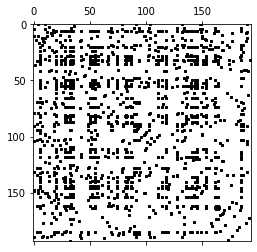

In [18]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3)
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')-1
X_test = np.asarray(X_test ).astype('float32')
y_test = np.asarray(y_test).astype('float32')-1
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float64)


assert A.shape == (194, 194)
print('d = |V| = {}, k|V| < |E| = {}'.format(450, A.nnz))
#print(plt.spy(A, markersize=2, color='black'))
plt.spy(F, markersize=2, color = 'black')


In [19]:
graphs, perm = coarsening.coarsen(F, levels=5, self_connections=False)
#Any reason for coarsening into 3 levels? What's significance of levels?
X_train = coarsening.perm_data(X_train, perm)
X_test = coarsening.perm_data(X_test, perm)
L = [graph.laplacian(F, normalized=True) for F in graphs]

#graph.plot_spectrum(L)

Layer 0: M_0 = |V| = 832 nodes (638 added),|E| = 744 edges
Layer 1: M_1 = |V| = 416 nodes (311 added),|E| = 405 edges
Layer 2: M_2 = |V| = 208 nodes (145 added),|E| = 194 edges
Layer 3: M_3 = |V| = 104 nodes (61 added),|E| = 85 edges
Layer 4: M_4 = |V| = 52 nodes (20 added),|E| = 26 edges
Layer 5: M_5 = |V| = 26 nodes (0 added),|E| = 8 edges


In [20]:
C = 2
common = {}
common['dir_name']       = 'PPI/'
common['num_epochs']     = 1000
common['batch_size']     = 100
common['decay_steps']    = 17.7 # * common['num_epochs'] since not used use as in momentum 
common['eval_frequency'] = 100 #* common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'apool1'

model_perf = utils.model_perf()

common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = .005
common['decay_rate']     = 0.95
common['momentum']       = 0

common['F']              = [1]
common['K']              = [1]
common['p']              = [2]
common['M']              = [8,C]

In [21]:
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
name = 'Run1'
params = common.copy()
params['dir_name'] += name
#    params['filter'] = 'chebyshev5'
params['filter'] = 'chebyshev2'
params['brelu'] = 'b1relu'
model = models.cgcnn(L,**params)#params['F'],params['K'],params['p'],params['M'])
model.fit(X_train, y_train, X_test, y_test)

NN architecture
  input: M_0 = 832
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 832 * 1 / 2 = 416
    weights: F_0 * F_1 * K_1 = 1 * 1 * 1 = 1
    biases: F_1 = 1
  layer 2: fc1
    representation: M_2 = 8
    weights: M_1 * M_2 = 416 * 8 = 3328
    biases: M_2 = 8
  layer 3: logits (softmax)
    representation: M_3 = 2
    weights: M_2 * M_3 = 8 * 2 = 16
    biases: M_3 = 2


L type = float32
x type = <dtype: 'float32'>
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differen

([80.32786885245902,
  82.78688524590164,
  84.42622950819673,
  83.60655737704919,
  85.24590163934425,
  84.42622950819673,
  86.0655737704918,
  86.0655737704918,
  86.0655737704918,
  86.88524590163934,
  86.0655737704918,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934,
  86.88524590163934],
 [0.5752742779059489,
  0.4056761621451769,
  0.3537908379660278,
  0.33227885905347887,
  0.3206330244658423,
  0.3111089381282447,
  0.3068073973303936,
  0.30093623905396855,
  0.2986544559969277,
  0.29591621800524287,
  0.2948121274592447,
  0.2934130733130408,
  0.2925802541316533,
  0.2920520720911808,
  0.2914831133895233,
  0.2911267954795087,
  0.2908829080521083,
  0.2906698397681

In [22]:
# install tensorflow==1.15

In [23]:
tf.version.VERSION

'1.15.2'

In [24]:
!pwd

/content/GCN_Cancer/GCN_Cancer


In [25]:
import sklearn.metrics
import sklearn.neighbors
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
import tensorflow as tf
import numpy as np
import time
import h5py
import scipy.io as sio
import os
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
import sys
#sys.path.append("C:\Users\David\Downloads\lib\graph") 
from lib import graph
#sys.path.append("/Users/david/Downloads/lib/coarsening") 
from lib import coarsening
#sys.path.append("/Users/david/Downloads/lib/models") 
from lib import models
from lib import utils

In [26]:
flags = tf.compat.v1.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 1, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 1, 'Number of coarsened graphs.')


In [27]:
import sys
sys.argv = sys.argv[:1]
t_start = time.process_time()
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')
# Directories.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:

#For PPI and PPI-singleton model change file location
#test = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/Adj_Filtered_List_0Con.mat')
# for Correlaton model change file location
test = sio.loadmat('Adj_Spearman_6P.mat')
row = test['row'].astype(np.float32)
col = test['col'].astype(np.float32)
value = test['value'].astype(np.float32)
M, k = row.shape
row = np.array(row)
row = row.reshape(k)
row = row.ravel()
col = np.array(col)
col = col.reshape(k)
col = col.ravel()
value = np.array(value)
value = value.reshape(k)
value = value.ravel()
A = scipy.sparse.coo_matrix((value, (row, col)),shape = (3866,3866)) # change size for model being used 4444 for both PPI and 3866 for
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=True)
L = [graph.laplacian(A, normalized=True,renormalized=True) for A in graphs]
del test
del A
del row
del col
del value

FileNotFoundError: ignored

In [ ]:
test = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/Adj_Filtered_List_0Con.mat')
# for Correlaton model change file location
#test = sio.loadmat('Adj_Spearman_6P.mat')
row = test['row'].astype(np.float32)
col = test['col'].astype(np.float32)
value = test['value'].astype(np.float32)
M, k = row.shape
row = np.array(row)
row = row.reshape(k)
row = row.ravel()
col = np.array(col)
col = col.reshape(k)
col = col.ravel()
value = np.array(value)
value = value.reshape(k)
value = value.ravel()
print(value.shape)
A = scipy.sparse.coo_matrix((value, (row, col)),shape = (4444,4444))

print(A)

In [ ]:
#test = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/Adj_Filtered_List_0Con.mat')
## for Correlaton model change file location
##test = sio.loadmat('Adj_Spearman_6P.mat')
#row = test['row'].astype(np.float32)
#col = test['col'].astype(np.float32)
#value = test['value'].astype(np.float32)
#print(value)
#M, k = row.shape
#row = np.array(row)
#row = row.reshape(k)
#row = row.ravel()
#col = np.array(col)
#col = col.reshape(k)
#col = col.ravel()
#value = np.array(value)
#value = value.reshape(k)
#value = value.ravel()
#A = scipy.sparse.coo_matrix((value, (row, col)),shape = (4444,4444)) 

In [ ]:
FLAGS.coarsening_levels

In [ ]:
Data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/Block_PPIA.mat')
Data1 = Data['Block'][0,0]
Data2 = Data['Block'][0,1]
Data3 = Data['Block'][0,2]
Data4 = Data['Block'][0,3]
Data5 = Data['Block'][0,4]
D1= Data1['D'].astype(np.float32)
D2= Data2['D'].astype(np.float32)
D3= Data3['D'].astype(np.float32)
D4= Data4['D'].astype(np.float32)
D5= Data5['D'].astype(np.float32)
L1= Data1['L'].astype(np.float32)
L2= Data2['L'].astype(np.float32)
L3= Data3['L'].astype(np.float32)
L4= Data4['L'].astype(np.float32)
L5= Data5['L'].astype(np.float32)
# adjust for K-Fold cross validation
Train_Data = np.transpose(np.hstack((D1,D2,D3,D4)))
Val_Data = np.transpose(D5)
Test_Data = np.transpose(D5)
Train_Label = (np.vstack((L1,L2,L3,L4)))
Val_Label = (L5)
Test_Label = (L5)
Test_Label = Test_Label.ravel()
Train_Label = Train_Label.ravel()
Val_Label = Val_Label.ravel()

In [ ]:
len(perm)

In [ ]:
Train_Data = coarsening.perm_data(Train_Data, perm)
Val_Data = coarsening.perm_data(Val_Data, perm)
Test_Data = coarsening.perm_data(Test_Data, perm)

In [ ]:
C = 34  # number of classes

common = {}
common['dir_name']       = 'PPI/'
common['num_epochs']     = 2000
common['batch_size']     = 200
common['decay_steps']    = 17.7 # * common['num_epochs'] since not used use as in momentum 
common['eval_frequency'] = 1 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'apool1'

model_perf = utils.model_perf()

common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = .005
common['decay_rate']     = 0.95
common['momentum']       = 0

common['F']              = [1]
common['K']              = [1]
common['p']              = [2]
common['M']              = [128,C]


In [ ]:
import tensorflow.compat.v1 as tf1

In [ ]:
L

In [ ]:
if True:
    name = 'Run1'
    params = common.copy()
    params['dir_name'] += name
#    params['filter'] = 'chebyshev5'
    params['filter'] = 'chebyshev2'
    params['brelu'] = 'b1relu'
    #tf1.disable_v2_behavior()
    model_perf.test(models.cgcnn(L, **params), name, params, Train_Data, Train_Label, Val_Data, Val_Label, Test_Data, Test_Label)

model_perf.show()

if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))